In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt

from augmentor import SimplexNoiseWarpField

In [16]:
# Parameters to play with
size = 256
cell = 32  # checkerboard cell size
max_displacement = 16.0
frequency = 0.005
octaves = 5
lacunarity = 2.0
gain = 0.5

In [17]:
# Generate checkerboard
y, x = np.mgrid[:size, :size]
checkerboard = ((x // cell + y // cell) % 2).astype(np.float32)

# Run augmentation (skip=0 to always apply)
aug = SimplexNoiseWarpField(
    max_displacement=max_displacement,
    frequency=frequency,
    octaves=octaves,
    lacunarity=lacunarity,
    gain=gain,
    skip=0.0,
)
margin = int(math.ceil(max_displacement))
padded_size = size + 2 * margin

spec = {"input": (1, 1, size, size)}
expanded_spec = aug.prepare(spec, imgs=["input"])
print(f"Original spec: {spec}")
print(f"Expanded spec: {expanded_spec}")

# Pad checkerboard to expanded size
padded = np.pad(checkerboard, margin, mode="constant", constant_values=0)
sample = {"input": padded[np.newaxis, np.newaxis]}  # (1, 1, H, W)
result = aug(sample)
warped = result["input"][0, 0]

Original spec: {'input': (1, 1, 256, 256)}
Expanded spec: {'input': (1, 1, 288, 288)}


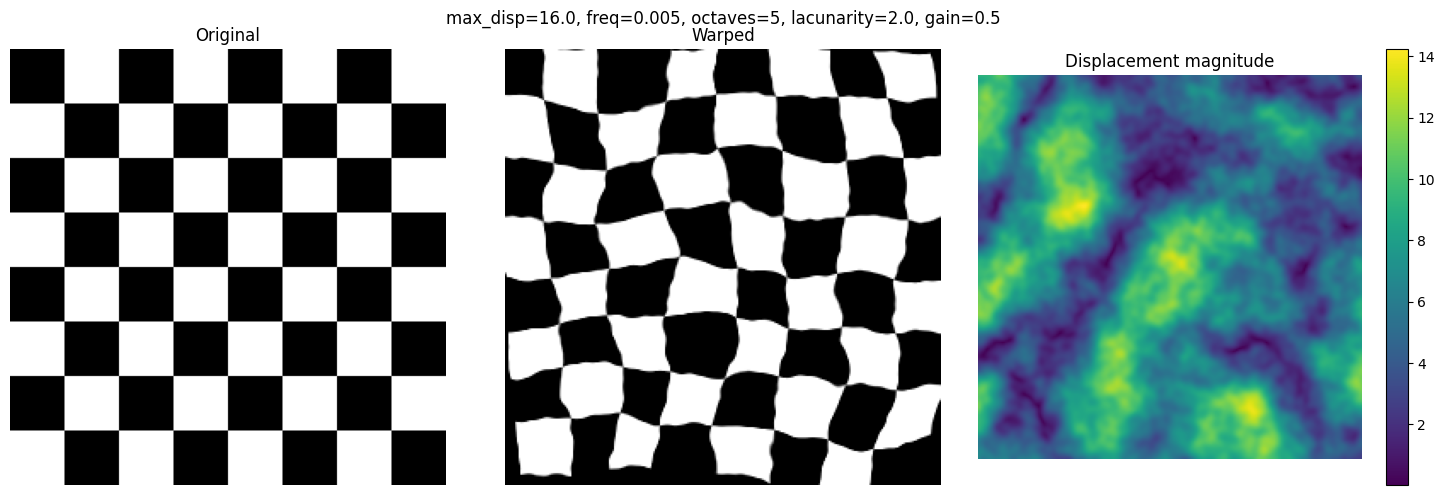

In [18]:
# Visualize: original, warped, displacement magnitude
dx, dy = aug._generate_field(padded_size, padded_size)
magnitude = np.sqrt(dx**2 + dy**2)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(checkerboard, cmap="gray")
axes[0].set_title("Original")
axes[1].imshow(warped, cmap="gray")
axes[1].set_title("Warped")
im = axes[2].imshow(magnitude[margin:-margin, margin:-margin], cmap="viridis")
axes[2].set_title("Displacement magnitude")
plt.colorbar(im, ax=axes[2])
for ax in axes:
    ax.axis("off")
plt.suptitle(
    f"max_disp={max_displacement}, freq={frequency}, "
    f"octaves={octaves}, lacunarity={lacunarity}, gain={gain}"
)
plt.tight_layout()
plt.show()

In [19]:
# Test with heterogeneous spec (different Z, Y, X per key)
spec_hetero = {
    "input": (1, 20, 128, 128),
    "label": (1, 16, 96, 96),
    "mask":  (1, 16, 96, 96),
}

aug2 = SimplexNoiseWarpField(
    max_displacement=16.0, frequency=0.005, octaves=5, skip=0.0
)
expanded = aug2.prepare(spec_hetero, imgs=["input"])
print(f"Original: {spec_hetero}")
print(f"Expanded: {expanded}")

# Create dummy data matching expanded spec
sample2 = {k: np.random.rand(*v).astype(np.float32) for k, v in expanded.items()}
result2 = aug2(sample2)

for k in result2:
    print(f"{k}: {result2[k].shape} (expected {spec_hetero[k]})")
    assert result2[k].shape == spec_hetero[k]

Original: {'input': (1, 20, 128, 128), 'label': (1, 16, 96, 96), 'mask': (1, 16, 96, 96)}
Expanded: {'input': (1, 20, 160, 160), 'label': (1, 16, 160, 160), 'mask': (1, 16, 160, 160)}
input: (1, 20, 128, 128) (expected (1, 20, 128, 128))
label: (1, 16, 96, 96) (expected (1, 16, 96, 96))
mask: (1, 16, 96, 96) (expected (1, 16, 96, 96))


In [20]:
# Test 3D mode (z_anisotropy): animate warp field varying across Z
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Z = 20
aug3d = SimplexNoiseWarpField(
    max_displacement=max_displacement,
    frequency=frequency,
    octaves=octaves,
    lacunarity=lacunarity,
    gain=gain,
    skip=0.0,
    z_anisotropy=100.0 / 20.0,  # e.g. 100x100x20 nm voxels
)

spec3d = {"input": (1, Z, size, size)}
expanded3d = aug3d.prepare(spec3d, imgs=["input"])
print(f"Original spec: {spec3d}")
print(f"Expanded spec: {expanded3d}")

# Build a 3D checkerboard stack
exp_z = expanded3d["input"][-3]
stack = np.stack([checkerboard] * exp_z, axis=0)
padded3d = np.pad(stack, ((0, 0), (margin, margin), (margin, margin)),
                  mode="constant", constant_values=0)
sample3d = {"input": padded3d[np.newaxis]}  # (1, Z, H, W)
result3d = aug3d(sample3d)
warped3d = result3d["input"][0]  # (Z, H, W)

assert warped3d.shape == (Z, size, size)
assert not np.allclose(warped3d[0], warped3d[-1]), "First and last slices should differ"

# Animate Z-slices
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(warped3d[0], cmap="gray", vmin=0, vmax=1)
title = ax.set_title("Z=0")
ax.axis("off")

def update(z):
    im.set_data(warped3d[z])
    title.set_text(f"Z={z}")
    return im, title

anim = FuncAnimation(fig, update, frames=Z, interval=200, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

Original spec: {'input': (1, 20, 256, 256)}
Expanded spec: {'input': (1, 20, 288, 288)}
